In [2]:
import os
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

# from sklearn.cluster import KMeans, spectral_clustering
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.metrics import silhouette_score, silhouette_samples
from copy import deepcopy

In [3]:
os.chdir("/home/g.esposito/sc2-benchmark")
path = os.getcwd()

log_folders = [file_path for file_path in os.listdir("/home/g.esposito/sc2-benchmark") if file_path.startswith("FSIM_W_hpc_obj_v2_")]
# print(log_folders)

general_report = pd.DataFrame([])
new_report = pd.DataFrame([])

for layer_conf in log_folders:
    if layer_conf != ".DS_Store":
        folder_path = os.path.join(path,  layer_conf)
        for cnf in [files for files in os.listdir(folder_path) if files != ".DS_Store"]:
            file_path = os.path.join(folder_path, cnf)

            report_path = os.path.join(file_path, "Faulty_boxes_report.csv")
            report = pd.read_csv(report_path)
            report['conf_detail'] = cnf.split("_")[0] if cnf.split("_")[0] != "cnf77" else "teacher_cnf"
            # print(report.columns)
            report['bit_faulty_position'] = np.log2(report['bitmask'])
            report.drop(columns=['Unnamed: 0'], inplace=True)
            general_report = pd.concat([general_report, report], axis=0, ignore_index=True)

            new_path = os.path.join(file_path, "fsim_full_report.csv")
            additional_report = pd.read_csv(new_path)
            additional_report['bit_faulty_position'] = np.log2(report['bitmask'])
            additional_report.drop(columns=['kernel.1','channel.1','row.1','col.1','BitMask', 'Unnamed: 0'], inplace=True)

            indices = additional_report.query("boxes_Crit==0 and boxes_SDC==0 and boxes_Masked == 0").index
            for idx in indices:
                additional_report.loc[idx, 'boxes_Crit'] = additional_report.loc[idx, 'average_golden_boxes']*100

            tot_boxes_per_fault = additional_report['boxes_Crit'] + additional_report['boxes_SDC'] + additional_report['boxes_Masked']
            additional_report['Crit_perc'] = (additional_report['boxes_Crit'] / tot_boxes_per_fault)*100
            additional_report['SDC_perc'] = (additional_report['boxes_SDC'] / tot_boxes_per_fault)*100
            additional_report['masked_perc'] = (additional_report['boxes_Masked'] / tot_boxes_per_fault)*100
            new_report = pd.concat([new_report, additional_report], axis=0, ignore_index=True)


general_report['iou_score'] = general_report['iou score']
general_report.drop(columns="iou score", inplace=True)
general_report.describe()
new_report.head()

,layer,kernel,channel,row,col,bitmask,gold_iou@1,boxes_Crit,boxes_SDC,boxes_Masked,...,average_faulty_boxes,average_target_boxes,Layer,Ffree_Weight,Faulty_weight,Abs_error,bit_faulty_position,Crit_perc,SDC_perc,masked_perc
0,3,23,251,0,1,1048576,70.200417,0,549,30,...,6.87,7.78,3.0,1.052182e+09,1.051133e+09,0.031250,29.0,0.000000,94.818653,5.181347
1,3,8,192,1,0,536870912,70.200417,5,554,20,...,6.90,7.78,3.0,3.161246e+09,2.624375e+09,-0.014452,29.0,0.863558,95.682211,3.454231
2,3,61,156,0,1,33554432,70.200417,4,425,150,...,6.88,7.78,3.0,3.184007e+09,3.217561e+09,1.465479,29.0,0.690846,73.402418,25.906736
3,3,9,190,1,1,67108864,70.200417,14,564,1,...,6.81,7.78,3.0,1.035613e+09,9.685037e+08,0.090560,29.0,2.417962,97.409326,0.172712
4,3,13,200,1,1,2147483648,70.200417,12,567,0,...,6.83,7.78,3.0,3.188422e+09,1.040938e+09,-0.272377,29.0,2.072539,97.927461,0.000000


In [4]:
counter = 0
print(len(general_report.query("F_lab!=G_lab")))
print(len(general_report))

1496712
2411974


In [5]:
# general_report.query("F_lab!=G_lab").describe()
general_report.query("iou_score < 90 and F_lab==G_lab and confidence_covered==1.0").describe()

,imID,layer,kernel,channel,row,col,bitmask,G_lab,F_count,F_lab,G_count,G_score,T_count,area_ratio,confidence_covered,f_candidate_conf,bit_faulty_position,iou_score
count,888188.000000,888188.000000,888188.000000,888188.00000,888188.000000,888188.000000,8.881880e+05,888188.000000,888188.000000,888188.000000,888188.000000,888188.000000,888188.000000,888188.000000,888188.0,888188.000000,888188.000000,888188.000000
mean,54.459933,2.010535,35.939810,31.70213,1.123922,1.123432,3.722225e+08,26.650331,12.215982,26.650331,10.671305,87.207421,12.947137,102.994764,1.0,85.942701,25.823344,79.552119
std,30.240715,1.589728,51.272205,39.87830,1.507188,1.517405,6.879588e+08,27.932322,7.575250,27.932322,6.450711,9.063985,8.109325,72.028023,0.0,10.656385,3.089016,16.549630
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.048576e+06,1.000000,1.000000,1.000000,1.000000,70.001930,1.000000,0.462736,1.0,60.000134,20.000000,0.000000
25%,26.000000,1.000000,2.000000,2.00000,0.000000,0.000000,1.677722e+07,1.000000,7.000000,1.000000,6.000000,79.068840,7.000000,88.756614,1.0,77.447385,24.000000,77.897649
50%,59.000000,2.000000,20.000000,24.00000,1.000000,1.000000,6.710886e+07,9.000000,11.000000,9.000000,10.000000,89.036024,12.000000,100.000000,1.0,88.344857,26.000000,84.902085
75%,79.000000,4.000000,47.000000,46.00000,1.000000,1.000000,2.684355e+08,56.000000,15.000000,56.000000,13.000000,95.450270,17.000000,112.951115,1.0,95.329368,28.000000,88.125150
max,99.000000,4.000000,255.000000,255.00000,6.000000,6.000000,2.147484e+09,88.000000,43.000000,88.000000,29.000000,99.986994,34.000000,15638.709677,1.0,100.000000,31.000000,89.999874


In [6]:
general_report.query("iou_score < 90 and F_lab==G_lab").groupby(by="layer").count()

,FaultID,imID,kernel,channel,row,col,bitmask,G_lab,g_bb,F_count,F_lab,G_count,G_score,T_count,area_ratio,confidence_covered,f_candidate_conf,conf_detail,bit_faulty_position,iou_score
layer,,,,,,,,,,,,,,,,,,,,
0,217243,217243,217243,217243,217243,217243,217243,217243,217243,217243,217243,217243,217243,217243,217243,217243,217243,217243,217243,217243
1,204620,204620,204620,204620,204620,204620,204620,204620,204620,204620,204620,204620,204620,204620,204620,204620,204620,204620,204620,204620
2,129423,129423,129423,129423,129423,129423,129423,129423,129423,129423,129423,129423,129423,129423,129423,129423,129423,129423,129423,129423
3,69691,69691,69691,69691,69691,69691,69691,69691,69691,69691,69691,69691,69691,69691,69691,69691,69691,69691,69691,69691
4,290373,290373,290373,290373,290373,290373,290373,290373,290373,290373,290373,290373,290373,290373,290373,290373,290373,290373,290373,290373


## Regression Task Criticality

In [7]:
print(f'Percentage of critical boxes because of the low iou score: {len(general_report.query("iou_score < 90 and F_lab==G_lab and confidence_covered==1.0"))/len(general_report)}')

Percentage of critical boxes because of the low iou score: 0.36824111702696627


Most of the boxes are here reported because of the iou_score which is critical and not for the different label

In [8]:
general_report['confidence_ratio'] = general_report['f_candidate_conf'] / general_report['G_score']
score_report = general_report.query("iou_score < 90 and F_lab==G_lab and confidence_covered==1.0")
# general_report['confidence_ratio'].describe()

While the confidence ratio has a variability around 1 that is low (that means that the confidence of the model in predicting something does not change too much), the iou_score is more sensible.

On the basis of the resilience (iou_score), models  can be ranked with respect to the interquantile distance:
- teacher_cnf
- cnf1
- cnf6
- cnf3
- cnf9
- cnf2
- cnf12

## Area ratio

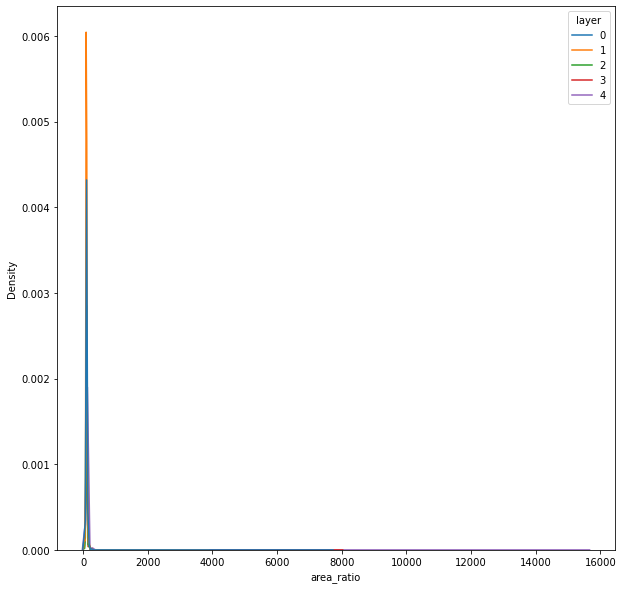

In [9]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.kdeplot(ax=ax, data=score_report, x= 'area_ratio', hue='layer', palette="tab10")

In [10]:
score_report[score_report['area_ratio']>200].groupby(by='conf_detail').groups
for key, indices in score_report[score_report['area_ratio']>200].groupby(by='layer').groups.items():
    print(f'{key}: {len(indices)}')

0: 1312
1: 993
2: 479
3: 204
4: 2660


In [11]:
print(f"number of boxes whose area is the double of the fault free model: {len(score_report[score_report['area_ratio']>200])}")
print(f"which represents the {(len(score_report[score_report['area_ratio']>200]) / len(score_report))*100}% of the total critical boxes")

number of boxes whose area is the double of the fault free model: 5648
which represents the 0.6359014082604133% of the total critical boxes


In these plots we can see where are the most critical points in terms of area ratio

### Cutting off these outliers let us see the distribution

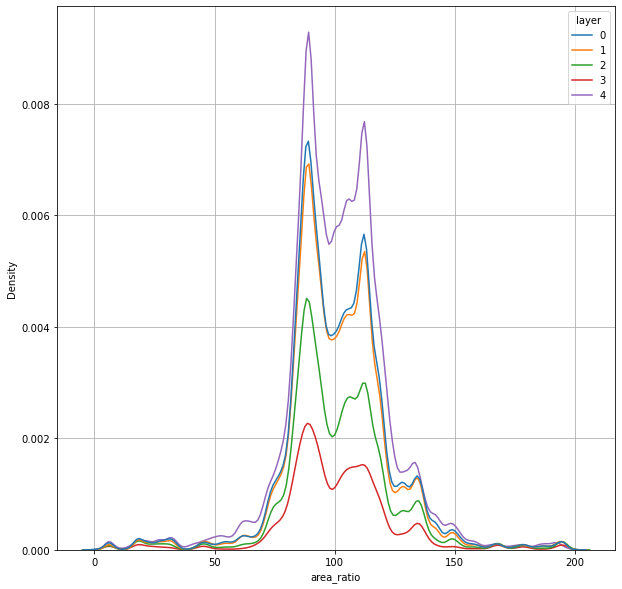

In [12]:
normal_area = score_report[score_report['area_ratio']<200]
fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.kdeplot(ax=ax, data=normal_area, x= 'area_ratio', hue='layer', palette="tab10")
ax.grid()
# this is a probability, then it is already normalized. 

## Classification task evaluation

In [13]:
general_report['confidence_ratio'] = general_report['f_candidate_conf'] / general_report['G_score']
score_report = general_report.query("F_lab!=G_lab and confidence_covered==1.0")

## Confidence analysis

In [14]:
general_report['confidence_ratio'] = general_report['f_candidate_conf'] / general_report['G_score']
# score_report = general_report.query("confidence_covered==0.0")
crit_perc_per_layer_per_bit = new_report.groupby(by=["bit_faulty_position", "layer"]).mean()['Crit_perc']/100
general_report['confidence_coverage'] = general_report.groupby(by=['layer', 'bit_faulty_position'])['confidence_covered'].transform(lambda x: x.sum())
general_report['confidence_coverage']

0           6719.0
1           6719.0
2           6719.0
3           6719.0
4           6719.0
            ...   
2411969    15807.0
2411970    15807.0
2411971    15807.0
2411972    15807.0
2411973    15807.0
Name: confidence_coverage, Length: 2411974, dtype: float64

In [20]:
new_report.columns

Index(['layer', 'kernel', 'channel', 'row', 'col', 'bitmask', 'gold_iou@1',
       'boxes_Crit', 'boxes_SDC', 'boxes_Masked', 'fault_iou@1', 'Class',
       'area_ratio', 'average_golden_boxes', 'average_faulty_boxes',
       'average_target_boxes', 'Layer', 'Ffree_Weight', 'Faulty_weight',
       'Abs_error', 'bit_faulty_position', 'Crit_perc', 'SDC_perc',
       'masked_perc'],
      dtype='object')

In [25]:
crit_perc_per_layer_per_bit = new_report.groupby(by=["bit_faulty_position", "layer"]).sum()['boxes_Crit'] + new_report.groupby(by=["bit_faulty_position", "layer"]).sum()['boxes_SDC'] + new_report.groupby(by=["bit_faulty_position", "layer"]).sum()['boxes_Masked']

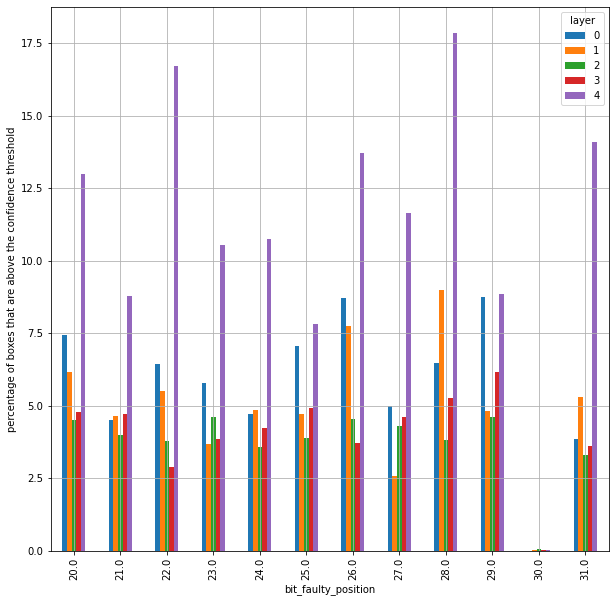

In [31]:
grouped_confidence = general_report.groupby(by=['layer', 'bit_faulty_position'])['confidence_covered'].sum()/crit_perc_per_layer_per_bit*100
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_ylabel('percentage of boxes that are above the confidence threshold')
grouped_confidence.unstack().transpose().plot(kind="bar", ax = ax, grid=True)

Text(0.5, 1.0, 'Confidence coverage VS bit position BY configuration')

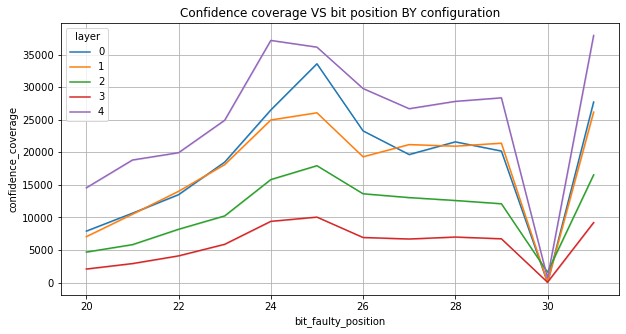

In [17]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.lineplot(ax=ax, data = general_report, x = 'bit_faulty_position', y = 'confidence_coverage', hue='layer', palette="tab10")
ax.grid()
ax.set_title("Confidence coverage VS bit position BY configuration")


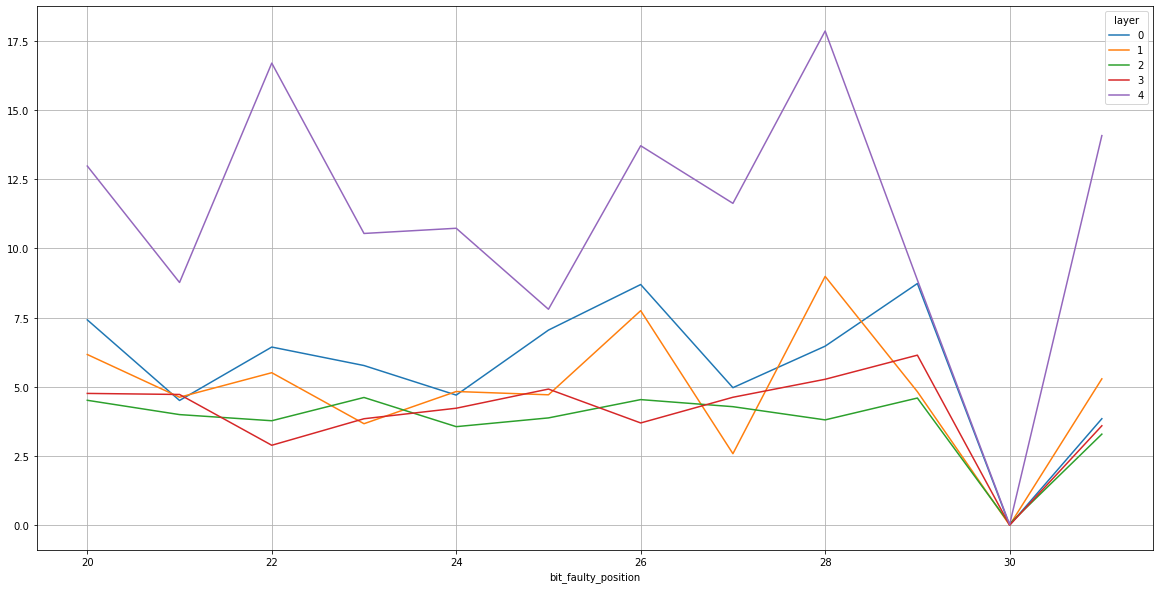

In [34]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
grouped_confidence.unstack().transpose().plot(kind="line", ax = ax, grid=True)

In [10]:
# fig, ax = plt.subplots(1,1, figsize=(10,5))
general_report['majority'] = None
indices_f_maj = general_report.query("F_count > G_count").index
general_report.loc[indices_f_maj,'majority'] = 'F_maj'

indices_g_maj = general_report.query("F_count < G_count").index
general_report.loc[indices_g_maj,'majority'] = 'G_maj'
# for idx in indices:
indices_eq = general_report.query("F_count == G_count").index
general_report.loc[indices_eq,'majority'] = 'eq'

# nan_indices = general_report.isna().index
nan_indices = general_report.query("F_lab.isnull()").index
general_report.loc[nan_indices,'majority'] = 'not_predicted'

FaultID                      0
imID                         0
layer                        0
kernel                       0
channel                      0
row                          0
col                          0
bitmask                      0
G_lab                        0
g_bb                         0
F_count                      0
F_lab                  1430236
G_count                      0
G_score                      0
T_count                      0
area_ratio             1430236
confidence_covered           0
f_candidate_conf       1430236
conf_detail                  0
bit_faulty_position          0
iou_score              1430236
majority                     0
dtype: int64

In [5]:
new_report.groupby(by='layer')['boxes_Masked'].sum()


layer
0     65831
1     86915
2    245600
3    928485
4    358825
Name: boxes_Masked, dtype: int64

In [11]:
category_totals = general_report['layer'].value_counts()
def calculate_percentage(row):
    category_total = category_totals[row['layer']]
    return (row['counting'] / category_total) * 100

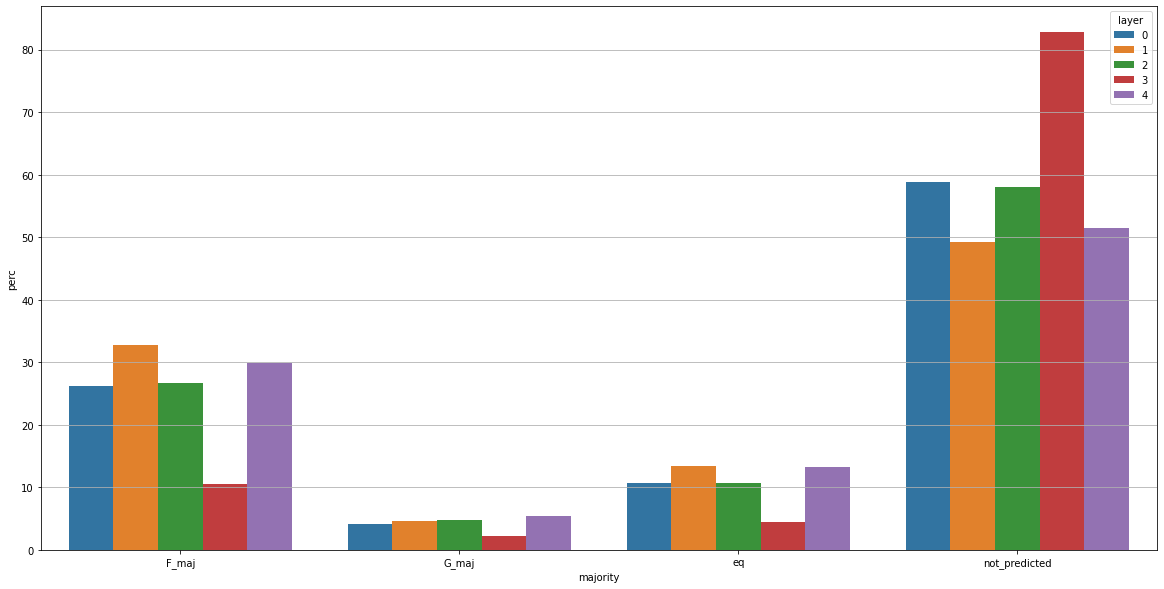

In [12]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
counts = general_report.groupby(['layer', 'majority']).size().reset_index(name='counting')
counts['perc'] = counts.apply(calculate_percentage, axis=1)

ax.grid()
sns.barplot(x='majority', y='perc', hue='layer', data=counts, ax = ax)